Step 1 : Download EOD bhavcopies (1/1/2016 to 31/12/2016) from NSE (https://www1.nseindia.com/products/content/equities/equities/archieve_eq.htm) and extract and create two separate csv files for HDFC and HDFCBANK 
Step 2 :   Calculate the ratio between HDFCBANK and HDFC
Step 3 :   Calculate the 10 day mean of the ratio
Step 4 :   Calculate the 2 SD bollinger bands
Step 5 :   Generate Buy Sell Short Cover trade signals
Step 6 :   Populate tradelist for the system
Step 7 :   Compute gross p&l (INR and %), transaction costs, net p&l (INR and %)
Step 8 :   Calculate output statistics (XIRR, MDD)
Step 9 :   Generate portfolio equity curve
Step 10 :   Calculate monthly profit table

In [95]:
import requests
import datetime 
from zipfile import ZipFile
import pandas as pd
import os
import glob
from pathlib import Path
from pyxirr import xirr
from datetime import date
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

In [10]:
extension = 'csv'
start='01-01-2016'
end='31-12-2016'
start=datetime.datetime.strptime(start,"%d-%m-%Y").date()
end=datetime.datetime.strptime(end,"%d-%m-%Y").date()
delta = datetime.timedelta(days=1)
#cm01JAN2016bhav.csv

path=r'C:\Users\admin\Desktop\Assignment'
while(start<=end):
    try:
        url = r'https://www1.nseindia.com/content/historical/EQUITIES/'+start.strftime("%Y")+'/'+start.strftime("%b").upper()+'/cm'+start.strftime("%d%b%Y").upper()+'bhav.csv.zip'
        #print(url)
        req=requests.get(url)
        filename=url.split('/')[-1]
        with open(path+'/'+filename,'wb') as output_file:
            output_file.write(req.content)
        with ZipFile(path+'/'+filename,'r') as zip_ref:
            zip_ref.extractall(path)
    except:
        pass
    start+=delta

In [18]:
path=Path(r'C:\Users\admin\Desktop\Assignment')
files = [i for i in path.glob('*.{}'.format(extension))]
combined_csv=pd.concat([pd.read_csv(f) for f in files])
combined_csv.to_csv("Combined.csv",index=False)

In [96]:
df= pd.read_csv(r'C:\Users\admin\Desktop\Python\Combined.csv')

In [97]:
df_1=df[(df['SYMBOL']=='HDFC') & (df['SERIES']=='EQ')]
df_2=df[(df['SYMBOL']=='HDFCBANK') & (df['SERIES']=='EQ')]
df_1=df_1[['TIMESTAMP','CLOSE']]
df_2=df_2[['TIMESTAMP','CLOSE']]

In [98]:
df_1 = pd.merge(df_1,df_2,on='TIMESTAMP')
df_1['TIMESTAMP'] = pd.to_datetime(df_1['TIMESTAMP'])
df_1 = df_1.sort_values(by='TIMESTAMP')
df_1.reset_index(inplace=True,drop=True)

In [99]:
print(df_1)

     TIMESTAMP  CLOSE_x  CLOSE_y
0   2016-01-01  1258.45  1088.75
1   2016-01-04  1216.70  1070.50
2   2016-01-05  1209.40  1062.40
3   2016-01-06  1209.30  1067.10
4   2016-01-07  1179.45  1056.20
..         ...      ...      ...
242 2016-12-26  1219.50  1175.00
243 2016-12-27  1232.15  1185.20
244 2016-12-28  1237.95  1186.75
245 2016-12-29  1257.20  1205.20
246 2016-12-30  1262.60  1206.20

[247 rows x 3 columns]


In [100]:
df_1['Ratio']=df_1['CLOSE_y']/df_1['CLOSE_x']
display(df_1)

,TIMESTAMP,CLOSE_x,CLOSE_y,Ratio
0,2016-01-01,1258.45,1088.75,0.865152
1,2016-01-04,1216.70,1070.50,0.879839
2,2016-01-05,1209.40,1062.40,0.878452
3,2016-01-06,1209.30,1067.10,0.882411
4,2016-01-07,1179.45,1056.20,0.895502
...,...,...,...,...
242,2016-12-26,1219.50,1175.00,0.963510
243,2016-12-27,1232.15,1185.20,0.961896
244,2016-12-28,1237.95,1186.75,0.958641
245,2016-12-29,1257.20,1205.20,0.958638


In [101]:
ma=int(input("Enter Moving Average "))
sd=int(input("Enter SD "))
df_1['MA']=df_1['Ratio'].rolling(ma).mean()
df_1['SD'] = df_1['Ratio'].rolling(ma).std()
df_1['UpperBand']=df_1['MA']+(df_1['SD']*sd)
df_1['LowerBand']=df_1['MA']-(df_1['SD']*sd)

Enter Moving Average 10
Enter SD 1


In [102]:
#display(df_1)

In [103]:
buy_c=0
sell_c=0
short_c=0
cover_c=0
for i in range(0,len(df_1)):
    if(buy_c>sell_c):
        if(df_1.loc[i,'Ratio']>df_1.loc[i,'MA']):
            df_1.loc[i,'Sell']=1
            sell_c+=1
    if((df_1.loc[i,'Ratio']<df_1.loc[i,'LowerBand']) & (sell_c==buy_c) & (short_c==cover_c)):
        df_1.loc[i,'Buy']=1
        buy_c+=1
    if(short_c>cover_c):
        if(df_1.loc[i,'Ratio']<df_1.loc[i,'MA']):
            df_1.loc[i,'Cover']=1
            cover_c+=1
    if((df_1.loc[i,'Ratio']>df_1.loc[i,'UpperBand']) & (short_c==cover_c) & (sell_c==buy_c)):
        df_1.loc[i,'Short']=1
        short_c+=1
    
#display(df_1)
#df_1.to_csv('test2.csv')    

In [104]:
for i in range(0,len(df_1)):
    if((df_1.loc[i,'Buy']==1) | (df_1.loc[i,'Sell']==1) | (df_1.loc[i,'Short']==1) | (df_1.loc[i,'Cover']==1)):
        df_1.loc[i,'Price_HDFCBANK'] = df_1.loc[i,'CLOSE_y']
        df_1.loc[i,'Price_HDFC'] = df_1.loc[i,'CLOSE_x']
#display(df_1)

In [105]:
entry = df_1[(df_1['Buy']==1) | (df_1['Short']==1)]
entry.reset_index(inplace=True,drop=True)
display(entry)

,TIMESTAMP,CLOSE_x,CLOSE_y,Ratio,MA,SD,UpperBand,LowerBand,Buy,Sell,Short,Cover,Price_HDFCBANK,Price_HDFC
0,2016-01-20,1136.65,1018.30,0.895878,0.904082,0.005558,0.909640,0.898524,1.0,NaN,NaN,NaN,1018.30,1136.65
1,2016-02-09,1159.90,1026.05,0.884602,0.892869,0.005538,0.898407,0.887332,1.0,NaN,NaN,NaN,1026.05,1159.90
2,2016-02-10,1116.55,1012.95,0.907214,0.895070,0.006452,0.901522,0.888618,NaN,1.0,1.0,NaN,1012.95,1116.55
3,2016-02-18,1069.10,989.45,0.925498,0.902050,0.012166,0.914217,0.889884,NaN,NaN,1.0,NaN,989.45,1069.10
4,2016-03-03,1124.15,1015.85,0.903661,0.919131,0.010819,0.929950,0.908312,1.0,NaN,NaN,NaN,1015.85,1124.15
5,2016-03-15,1111.35,1026.70,0.923831,0.901913,0.015247,0.917160,0.886666,NaN,1.0,1.0,NaN,1026.70,1111.35
6,2016-03-29,1125.75,1053.80,0.936087,0.912072,0.013480,0.925552,0.898592,NaN,NaN,1.0,NaN,1053.80,1125.75
7,2016-04-21,1150.10,1091.15,0.948744,0.969767,0.013507,0.983274,0.956260,1.0,NaN,NaN,NaN,1091.15,1150.10
8,2016-04-26,1127.30,1113.85,0.988069,0.972657,0.013618,0.986275,0.959039,NaN,NaN,1.0,NaN,1113.85,1127.30
9,2016-05-05,1162.65,1132.30,0.973896,1.001695,0.024655,1.026350,0.977040,1.0,NaN,NaN,NaN,1132.30,1162.65


In [106]:
exit = df_1[(df_1['Sell']==1) | (df_1['Cover']==1)]
exit.reset_index(inplace=True,drop=True)
#display(exit)

In [115]:
tradesheet = pd.DataFrame()
for i in range(len(entry)):
    tradesheet.loc[i,'EntryDate']=entry.loc[i,'TIMESTAMP']
    tradesheet.loc[i,'ExitDate']=exit.loc[i,'TIMESTAMP']
    tradesheet.loc[i,'Month']=exit.loc[i,'TIMESTAMP'].strftime("%m")
    
    if(entry.loc[i,'Buy']==1):
        tradesheet.loc[i,'Entry_Signal']='Buy'
    if(entry.loc[i,'Short']==1):
        tradesheet.loc[i,'Entry_Signal']='Short'
    if(exit.loc[i,'Sell']==1):
        tradesheet.loc[i,'Exit_Signal']='Sell'
    if(exit.loc[i,'Cover']==1):
        tradesheet.loc[i,'Exit_Signal']='Cover'
    
    tradesheet.loc[i,'HDFCBANK_Entry']=entry.loc[i,'Price_HDFCBANK']
    tradesheet.loc[i,'HDFC_Entry']=entry.loc[i,'Price_HDFC']
    tradesheet.loc[i,'HDFCBANK_Exit']=exit.loc[i,'Price_HDFCBANK']
    tradesheet.loc[i,'HDFC_Exit']=exit.loc[i,'Price_HDFC']
display(tradesheet)
    

,EntryDate,ExitDate,Month,Entry_Signal,Exit_Signal,HDFCBANK_Entry,HDFC_Entry,HDFCBANK_Exit,HDFC_Exit
0,2016-01-20,2016-01-28,01,Buy,Sell,1018.30,1136.65,1031.70,1147.75
1,2016-02-09,2016-02-10,02,Buy,Sell,1026.05,1159.90,1012.95,1116.55
2,2016-02-10,2016-02-12,02,Short,Cover,1012.95,1116.55,971.40,1083.75
3,2016-02-18,2016-02-25,02,Short,Cover,989.45,1069.10,942.65,1042.65
4,2016-03-03,2016-03-15,03,Buy,Sell,1015.85,1124.15,1026.70,1111.35
5,2016-03-15,2016-03-22,03,Short,Cover,1026.70,1111.35,1053.85,1168.10
6,2016-03-29,2016-04-13,04,Short,Cover,1053.80,1125.75,1081.75,1114.95
7,2016-04-21,2016-04-25,04,Buy,Sell,1091.15,1150.10,1093.25,1112.00
8,2016-04-26,2016-05-04,05,Short,Cover,1113.85,1127.30,1127.35,1129.90
9,2016-05-05,2016-05-13,05,Buy,Sell,1132.30,1162.65,1140.90,1166.00


In [119]:
count=1
tradesheet['MonthCount'].loc[0]=count
for i in range(1,len(tradesheet)):
    if(i<len(tradesheet)-1):
        if((tradesheet.loc[i,'Month'])==tradesheet.loc[i+1,'Month']):
            tradesheet.loc[i,'MonthCount']=count
            count+=1
        elif((tradesheet.loc[i,'Month']!=tradesheet.loc[i+1,'Month']) & (tradesheet.loc[i,'Month']==tradesheet.loc[i-1,'Month'])):
            tradesheet.loc[i,'MonthCount']=count
            count+=1
            count=1
        else:
            count=1
            tradesheet.loc[i,'MonthCount']=count
tradesheet['MonthCount'].iloc[-1]=count
display(tradesheet)

C:\Users\admin\AppData\Local\Temp\ipykernel_4572\2927243385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradesheet['MonthCount'].loc[0]=count
C:\Users\admin\AppData\Local\Temp\ipykernel_4572\2927243385.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradesheet['MonthCount'].iloc[-1]=count


,EntryDate,ExitDate,Month,Entry_Signal,Exit_Signal,HDFCBANK_Entry,HDFC_Entry,HDFCBANK_Exit,HDFC_Exit,MonthCount
0,2016-01-20,2016-01-28,01,Buy,Sell,1018.30,1136.65,1031.70,1147.75,1.0
1,2016-02-09,2016-02-10,02,Buy,Sell,1026.05,1159.90,1012.95,1116.55,1.0
2,2016-02-10,2016-02-12,02,Short,Cover,1012.95,1116.55,971.40,1083.75,2.0
3,2016-02-18,2016-02-25,02,Short,Cover,989.45,1069.10,942.65,1042.65,3.0
4,2016-03-03,2016-03-15,03,Buy,Sell,1015.85,1124.15,1026.70,1111.35,1.0
5,2016-03-15,2016-03-22,03,Short,Cover,1026.70,1111.35,1053.85,1168.10,2.0
6,2016-03-29,2016-04-13,04,Short,Cover,1053.80,1125.75,1081.75,1114.95,1.0
7,2016-04-21,2016-04-25,04,Buy,Sell,1091.15,1150.10,1093.25,1112.00,2.0
8,2016-04-26,2016-05-04,05,Short,Cover,1113.85,1127.30,1127.35,1129.90,1.0
9,2016-05-05,2016-05-13,05,Buy,Sell,1132.30,1162.65,1140.90,1166.00,2.0


In [109]:
for i in range(0,len(tradesheet)):
    if(i==0):
        tradesheet.loc[i,'HDFCBANK_CV']=500000
        tradesheet.loc[i,'HDFC_CV']=500000
    else:
        tradesheet.loc[i,'HDFCBANK_CV']=tradesheet.loc[i-1,'Ending capital']/2
        tradesheet.loc[i,'HDFC_CV']=tradesheet.loc[i-1,'Ending capital']/2
    tradesheet.loc[i,'Q1']=int((tradesheet.loc[i,'HDFCBANK_CV'])/tradesheet.loc[i,'HDFCBANK_Entry'])
    tradesheet.loc[i,'Q2']=int((tradesheet.loc[i,'HDFC_CV'])/tradesheet.loc[i,'HDFC_Entry'])
    
    if(tradesheet.loc[i,'Entry_Signal']=='Buy'):
        tradesheet.loc[i,'HDFCBANK_P/L']=((tradesheet.loc[i,'HDFCBANK_Exit'])-(tradesheet.loc[i,'HDFCBANK_Entry']))*tradesheet.loc[i,'Q1']
        tradesheet.loc[i,'HDFC_P/L']=((tradesheet.loc[i,'HDFC_Entry'])-(tradesheet.loc[i,'HDFC_Exit']))*tradesheet.loc[i,'Q2']
    if(tradesheet.loc[i,'Entry_Signal']=='Short'):
        tradesheet.loc[i,'HDFCBANK_P/L']=((tradesheet.loc[i,'HDFCBANK_Entry'])-(tradesheet.loc[i,'HDFCBANK_Exit']))*tradesheet.loc[i,'Q1']
        tradesheet.loc[i,'HDFC_P/L']=((tradesheet.loc[i,'HDFC_Exit'])-(tradesheet.loc[i,'HDFC_Entry']))*tradesheet.loc[i,'Q2']
    
    tradesheet.loc[i,'Gross_P/L']=tradesheet.loc[i,'HDFCBANK_P/L']+tradesheet.loc[i,'HDFC_P/L']
    tradesheet.loc[i,'Gross P/L %']=(tradesheet.loc[i,'Gross_P/L']/((tradesheet.loc[i,'HDFCBANK_CV'])+(tradesheet.loc[i,'HDFC_CV'])))*100
    tradesheet.loc[i,'TransactionCost']=((0.05/100*(tradesheet.loc[i,'Q1']*tradesheet.loc[i,'HDFCBANK_Entry']))+(0.05/100*(tradesheet.loc[i,'Q1']*tradesheet.loc[i,'HDFCBANK_Exit']))+(0.05/100*(tradesheet.loc[i,'Q2']*tradesheet.loc[i,'HDFC_Entry']))+(0.05/100*(tradesheet.loc[i,'Q2']*tradesheet.loc[i,'HDFC_Exit'])))
    tradesheet.loc[i,'Net P/L']=(tradesheet.loc[i,'Gross_P/L']-tradesheet.loc[i,'TransactionCost'])
    tradesheet.loc[i,'Ending capital']=tradesheet.loc[i,'Net P/L']+tradesheet.loc[i,'HDFCBANK_CV']+tradesheet.loc[i,'HDFC_CV']
    tradesheet.loc[i,'Net P/L %']=(tradesheet.loc[i,'Net P/L']/(tradesheet.loc[i,'HDFCBANK_CV']+tradesheet.loc[i,'HDFC_CV']))*100
tradesheet['MDD']=(tradesheet['Ending capital']/tradesheet['Ending capital'].rolling(len(tradesheet)-1,1).max())-1
display(tradesheet)

,EntryDate,ExitDate,Month,Entry_Signal,Exit_Signal,HDFCBANK_Entry,HDFC_Entry,HDFCBANK_Exit,HDFC_Exit,MonthCount,...,Q2,HDFCBANK_P/L,HDFC_P/L,Gross_P/L,Gross P/L %,TransactionCost,Net P/L,Ending capital,Net P/L %,MDD
0,2016-01-20,2016-01-28,01,Buy,Sell,1018.30,1136.65,1031.70,1147.75,NaN,...,439.0,6579.40,-4872.90,1706.50,0.170650,1004.700800,701.799200,1.000702e+06,0.070180,0.000000
1,2016-02-09,2016-02-10,02,Buy,Sell,1026.05,1159.90,1012.95,1116.55,1.0,...,431.0,-6379.70,18683.85,12304.15,1.229552,987.071475,11317.078525,1.012019e+06,1.130914,0.000000
2,2016-02-10,2016-02-12,02,Short,Cover,1012.95,1116.55,971.40,1083.75,2.0,...,453.0,20733.45,-14858.40,5875.05,0.580528,993.463275,4881.586725,1.016900e+06,0.482361,0.000000
3,2016-02-18,2016-02-25,02,Short,Cover,989.45,1069.10,942.65,1042.65,3.0,...,475.0,24008.40,-12563.75,11444.65,1.125444,997.124275,10447.525725,1.027348e+06,1.027389,0.000000
4,2016-03-03,2016-03-15,03,Buy,Sell,1015.85,1124.15,1026.70,1111.35,1.0,...,456.0,5479.25,5836.80,11316.05,1.101482,1025.437875,10290.612125,1.037639e+06,1.001668,0.000000
5,2016-03-15,2016-03-22,03,Short,Cover,1026.70,1111.35,1053.85,1168.10,2.0,...,466.0,-13710.75,26445.50,12734.75,1.227282,1056.450725,11678.299275,1.049317e+06,1.125469,0.000000
6,2016-03-29,2016-04-13,04,Short,Cover,1053.80,1125.75,1081.75,1114.95,1.0,...,466.0,-13891.15,-5032.80,-18923.95,-1.803454,1052.767275,-19976.717275,1.029340e+06,-1.903783,-0.019038
7,2016-04-21,2016-04-25,04,Buy,Sell,1091.15,1150.10,1093.25,1112.00,2.0,...,447.0,989.10,17030.70,18019.80,1.750617,1020.005550,16999.794450,1.046340e+06,1.651523,-0.002837
8,2016-04-26,2016-05-04,05,Short,Cover,1113.85,1127.30,1127.35,1129.90,1.0,...,464.0,-6331.50,1206.40,-5125.10,-0.489812,1049.231800,-6174.331800,1.040166e+06,-0.590088,-0.008721
9,2016-05-05,2016-05-13,05,Buy,Sell,1132.30,1162.65,1140.90,1166.00,2.0,...,447.0,3947.40,-1497.45,2449.95,0.235535,1042.152675,1407.797325,1.041573e+06,0.135344,-0.007380


In [110]:
opening_date = tradesheet['EntryDate'][0]
ending_date = tradesheet['ExitDate'].iloc[-1]
open_value=-1000000
end_value=tradesheet['Ending capital'].iloc[-1]

dates=[opening_date,ending_date]
amounts=[open_value,end_value]
XIRR=xirr(dates,amounts)
print("XIRR is ",XIRR)

XIRR is  0.13644174826784983


In [111]:
mdd = tradesheet['MDD'].min()
print("MDD is ",mdd)

MDD is  -0.019037830463814465


<AxesSubplot:xlabel='ExitDate'>

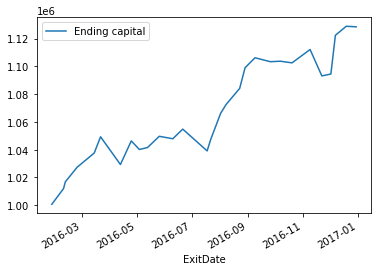

In [112]:
import matplotlib.pyplot as plt
tradesheet.plot(kind='line',x='ExitDate',y='Ending capital')

In [113]:
table = pd.pivot_table(tradesheet,values='Net P/L',index='MonthCount',columns='Month')
display(table)

Month,02,03,04,05,06,07,08,09,10,11,12
MonthCount,,,,,,,,,,,
1.0,11317.078525,10290.612125,-19976.717275,-6174.331800,-1774.70470,-15682.715525,18819.25040,7199.42810,361.259000,9603.007675,1364.826800
2.0,4881.586725,11678.299275,16999.794450,1407.797325,6935.92265,8319.401475,6276.36380,-2838.69805,-1186.925025,-19009.447350,27869.275925
3.0,10447.525725,NaN,NaN,8100.696000,NaN,NaN,11559.41110,NaN,NaN,NaN,6517.185000
4.0,NaN,NaN,NaN,NaN,NaN,NaN,14893.48675,NaN,NaN,NaN,-395.440050
